# Continuous Control

---

Congratulations for completing the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program!  In this notebook, you will learn how to control an agent in a more challenging environment, where the goal is to train a creature with four 
arms to walk forward.  **Note that this exercise is optional!**

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment

from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import pandas as pd
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from td3_agent import AgentTD3

**Next, we will start the environment!** Keep in mind that I was installing on Windows 10 (64bit) and the description on how to install under Windows can be found here: https://github.com/AntoniaSophia/DRLND_BananaCollector/blob/master/Report.md 
- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='../UnityReacher/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

When finished, you can close the environment.

In [5]:
def train_reacher(env, brain_name, n_episodes=500, max_t=10000, solved_score=1, consec_episodes=2, print_every=1,
               actor_path='actor_ckpt.pth', critic_path='critic_ckpt.pth'):
    """
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode
        solved_score (float)  : min avg score over consecutive episodes
        consec_episodes (int) : number of consecutive episodes used to calculate score
        print_every (int)     : interval to display results
        actor_path (str)      : directory to store actor network weights
        critic_path (str)     : directory to store critic network weights

    """

    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]
    brain = env.brains[brain_name]

    # number of agents
    num_agents = len(env_info.agents)
    print('Number of agents:', num_agents)

    # size of each action
    action_size = brain.vector_action_space_size
    print('Size of each action:', action_size)

    # examine the state space
    states = env_info.vector_observations
    state_size = states.shape[1]
    print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
    print('The state for the first agent looks like:', states[0])

    agent = AgentTD3(state_size=state_size, action_size=action_size,
                     random_seed=1)


    mean_scores = []                               # list of mean scores from each episode
    min_scores = []                                # list of lowest scores from each episode
    max_scores = []                                # list of highest scores from each episode
    best_score = -np.inf
    scores_window = deque(maxlen=consec_episodes)  # mean scores from most recent episodes
    moving_avgs = []                               # list of moving averages
    df = pd.DataFrame(columns=['episode', 'duration', 'min', 'max', 'std', 'mean'])

    # now execute up to maximum "maxEpisodes" episodes
    for i_episode in range(1, n_episodes+1):
        # 1.Step: reset the environment - set the train_mode to True !!
        env_info = env.reset(train_mode=True)[brain_name]  

        # 2. Step: get the current state for each agent
        states = env_info.vector_observations                  

        # 3.Step: set the score of the current episode to 0 for each agent
        scores = np.zeros(num_agents)                          

        agent.reset()
        start_time = time.time()

        # 4.Step: while episode has not ended (done = True or t < max_t) repeat
        for t in range(max_t):
            # 5.Step: Calculate the next action from agent with noise
            actions = agent.act(states, add_noise=True)        

            # 6.Step: Tell the environment about this action and get result
            env_info = env.step(actions)[brain_name]            

            # 7.Step: now let's get the state observation from observation            
            next_states = env_info.vector_observations          

            # 8.Step: now let's get the reward observation from observation            
            rewards = env_info.rewards                         

            # 9.Step: now let's get the done observation from observation
            dones = env_info.local_done                         

            # 10.Step: Add the reward of the last action-state result  
            scores += rewards

            # 11.Step: Execute a training step of the agent
            # save experience to replay buffer, perform learning step at defined interval
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)

            # 12.Step: Continue while-loop with next_state as current state            
            states = next_states

            # 13.Step: in case of end of episode print the result and break loop 
            if np.any(dones):                                   # exit loop when episode ends
                break

        duration = time.time() - start_time
        min_scores.append(np.min(scores))             # save lowest score for a single agent
        max_scores.append(np.max(scores))             # save highest score for a single agent
        mean_scores.append(np.mean(scores))           # save mean score for the episode
        scores_window.append(mean_scores[-1])         # save mean score to window
        moving_avgs.append(np.mean(scores_window))    # save moving average

        df.loc[i_episode-1] = [i_episode] + list([duration, np.min(scores),
                                                  np.max(scores),
                                                  np.std(scores),
                                                  np.mean(scores)])

        # 16.Step: Print results every print_every episodes 
        if i_episode % print_every == 0:
            print('\rEpisode {} ({} sec)  -- \tMin: {:.1f}\tMax: {:.1f}\tMean: {:.1f}\tMov. Avg: {:.1f}'.format(
                  i_episode, round(duration), min_scores[-1], max_scores[-1], mean_scores[-1], moving_avgs[-1]))


        # 17.Step: save actor and critic in case a new best score has been encountered 
        if mean_scores[-1] > best_score:
            torch.save(agent.actor_local.state_dict(), actor_path)
            torch.save(agent.critic_local.state_dict(), critic_path)

        # 18.Step: In case the performance "threshold" is exceeded --> stop and save the current agents neural network
        if moving_avgs[-1] >= solved_score and i_episode >= consec_episodes:
            print('\nEnvironment SOLVED in {} episodes!\tMoving Average ={:.1f} over last {} episodes'.format(
                i_episode-consec_episodes, moving_avgs[-1], consec_episodes))
            torch.save(agent.actor_local.state_dict(), actor_path)
            torch.save(agent.critic_local.state_dict(), critic_path)
            
            break
            
    return df


In [6]:
def plot_minmax(df):
    """Print min max plot of DQN Agent analytics

    Params
    ======
        df :    Dataframe with scores
    """
    ax = df.plot(x='episode', y='mean')
    plt.fill_between(x='episode', y1='min', y2='max', color='lightgrey', data=df)
    x_coordinates = [0, 180]
    y_coordinates = [30, 30]
    plt.plot(x_coordinates, y_coordinates, color='red')
    plt.show()

In [7]:
def test_reacher(env, brain_name, agent,  runs=100):
    # set overall sum of scores to 0
    mean_scores = []

    # now execute up to maximum runs episodes
    for i_episode in range(runs):

        # 1.Step: reset the environment - set the train_mode to False !!
        env_info = env.reset(train_mode=True)[brain_name]     

        # 2. Step: get the current state 
        states = env_info.vector_observations                  
        
        # 3.Step: set the score of the current episode to 0
        num_agents = len(env_info.agents)
        scores = np.zeros(num_agents)                          
        
        start_time = time.time()
        
        # 4.Step: while episode has not ended (done = True) repeat
        while True:
            # 5.Step: Calculate the next action from agent with epsilon 0 
            #         add_noise = False because we are not in training mode !
            actions = agent.act(states, add_noise=False)         

            # 6.Step: Tell the environment about this action and get result
            env_info = env.step(actions)[brain_name]           

            # 7.Step: now let's get the state observation from observation
            next_states = env_info.vector_observations         

            # 8.Step: now let's get the reward observation from observation
            rewards = env_info.rewards                        

            # 9.Step: now let's get the done observation from observation
            dones = env_info.local_done                         
            
            # 10.Step: Add the reward of the last action-state result  
            scores += env_info.rewards                         
            
            # 11.Step: Continue while-loop with next_state as current state
            states = next_states                                           

            # 12.Step: in case of end of episode print the result and break loop 
            if np.any(dones):                                 
                break

        # 13.Step: Finally append the score of last epsisode to the overall scores
        mean_scores.append(np.mean(scores))

        duration = time.time() - start_time
        print('\rEpisode {} ({} sec)\tMean: {:.1f}'.format(
            i_episode, round(duration), mean_scores[-1]))


    return mean_scores

In [8]:
def load_reacher(env, brain_name, actor_path, critic_path):

    # reset the environment
    env_info = env.reset(train_mode=False)[brain_name]
    brain = env.brains[brain_name]

    # number of agents
    num_agents = len(env_info.agents)
    print('Number of agents:', num_agents)

    # size of each action
    action_size = brain.vector_action_space_size
    print('Size of each action:', action_size)

    # examine the state space
    states = env_info.vector_observations
    state_size = states.shape[1]

    agent = AgentTD3(state_size=state_size, action_size=action_size,
                     random_seed=1)

    if torch.cuda.is_available():
        agent.actor_local.load_state_dict(torch.load(actor_path))
        agent.critic_local.load_state_dict(torch.load(critic_path))
    else:
        agent.actor_local.load_state_dict(torch.load(actor_path,
                                                     map_location=lambda storage, loc: storage))
        agent.critic_local.load_state_dict(torch.load(critic_path,
                                                      map_location=lambda storage, loc: storage))
    return agent


Initial setting of the hyper-parameters

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set the minimum score the agent has to reach in order to solve this task
threshold = 38.0

# this threshold has to be reached 2 episodes in a row
consec_episodes = 2

# Set the maximum number of episodes which the agent 
max_episodes = 150
max_t = 10000

# print result after every "print_every" episodes
print_every = 1

Now let's start with some training...

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.90150833e+00 -1.00000000e+00
  1.25147629e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -5.22214413e-01]
Episode 1 (961 sec)  -- 	Min: 0.2	Max: 3.3	Mean: 1.3	Mov. Avg: 1.3
Episode 2 (1011 sec)  -- 	Min: 0.6	Max: 3.9	Mean: 2.0	Mov. Avg: 1.6
Episode 3 (1021 sec)  -- 	Min: 1.7	Max: 5.5	Mean: 3.3	Mov. Avg: 2.7
Episode 4 (1040 sec)  -- 	Min: 2.1	Max: 5.3	Mean: 3.9	Mov. Avg: 3.6
Episode 5 (1021 sec)  -- 	Min: 1.6	Max: 5.2	Me

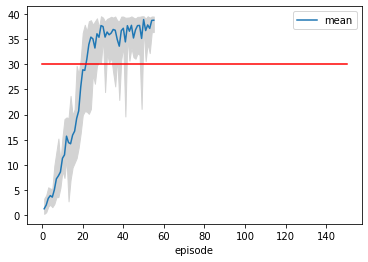

In [10]:
# Set the filename for storage of the trained model
# Set the filename for storage of the trained model
actor_filename = "actor_ckpt.pth"
critic_filename = "critic_ckpt.pth"

df = train_reacher(env, brain_name, max_episodes, max_t, threshold, consec_episodes, print_every,  \
                       actor_filename, critic_filename)

plot_minmax(df)
    

In [ ]:
print(df)

Now run the models with 100 episodes and calculate the overage reward

In [11]:
# Finally test the agent 

# load a previously stored solution
agent = load_reacher(env, brain_name, actor_filename , critic_filename)

# execute 100 consecutive tests and calculate the average score
runs = 100
scores = test_reacher(env, brain_name, agent,  runs)

print('Total score (averaged over agents) for 100 episodes: {}'.format(np.mean(scores)))

Number of agents: 20
Size of each action: 4
Episode 0 (4 sec)	Mean: 39.2
Episode 1 (4 sec)	Mean: 39.3
Episode 2 (5 sec)	Mean: 39.2
Episode 3 (5 sec)	Mean: 39.3
Episode 4 (5 sec)	Mean: 39.3
Episode 5 (5 sec)	Mean: 39.3
Episode 6 (5 sec)	Mean: 39.4
Episode 7 (5 sec)	Mean: 39.3
Episode 8 (5 sec)	Mean: 39.4
Episode 9 (5 sec)	Mean: 39.3
Episode 10 (6 sec)	Mean: 39.3
Episode 11 (6 sec)	Mean: 39.3
Episode 12 (6 sec)	Mean: 39.3
Episode 13 (5 sec)	Mean: 39.2
Episode 14 (6 sec)	Mean: 39.3
Episode 15 (5 sec)	Mean: 39.3
Episode 16 (6 sec)	Mean: 39.3
Episode 17 (5 sec)	Mean: 39.3
Episode 18 (5 sec)	Mean: 39.3
Episode 19 (5 sec)	Mean: 39.3
Episode 20 (5 sec)	Mean: 39.3
Episode 21 (5 sec)	Mean: 39.3
Episode 22 (5 sec)	Mean: 39.3
Episode 23 (5 sec)	Mean: 39.3
Episode 24 (5 sec)	Mean: 39.3
Episode 25 (6 sec)	Mean: 39.2
Episode 26 (5 sec)	Mean: 39.2
Episode 27 (5 sec)	Mean: 39.4
Episode 28 (5 sec)	Mean: 39.4
Episode 29 (5 sec)	Mean: 39.3
Episode 30 (5 sec)	Mean: 39.3
Episode 31 (5 sec)	Mean: 39.2
Episod

Now let's check how the algorithm performs in case we continue even after solving the task and run over 180 episodes irrespectively of the average reward

In [16]:
# Set the minimum score the agent has to reach in order to solve this task
threshold = 40.0

# this threshold has to be reached 2 episodes in a row
consec_episodes = 100

# Set the maximum number of episodes which the agent 
max_episodes = 180

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.35711288e+00 -1.00000000e+00
  6.70936584e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -8.02230597e-01]
Episode 1 (943 sec)  -- 	Min: 0.0	Max: 1.3	Mean: 0.6	Mov. Avg: 0.6


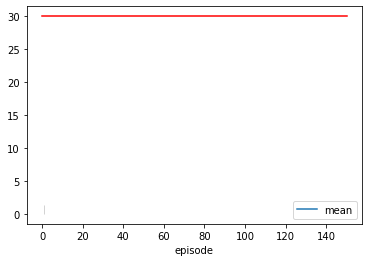

In [17]:
# Set the filename for storage of the trained model
# Set the filename for storage of the trained model
actor_filename = "actor_ckpt_long.pth"
critic_filename = "critic_ckpt_long.pth"

df = train_reacher(env, brain_name, max_episodes, max_t, threshold, consec_episodes, print_every,  \
                       actor_filename, critic_filename)

plot_minmax(df)

In [ ]:
# When finished, you can close the environment.
env.close()